## Project: Sign language exercise

---
### 1. Import the libraries that we need

In [98]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy

from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [99]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [100]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 1
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)
# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.compat.v1.set_random_seed(seed_value)

### 2. Data preparation

In [101]:
train_path  = 'dataset\sorted_train'#_test_less'
# valid_path  = 'dataset/valid'
# test_path  = 'dataset/sorted_test'

In [102]:
# ImageDataGenerator generates batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches).
# in this example, we won't be doing any image augmentation
# train_batches = ImageDataGenerator().flow_from_directory(train_path, 
#                                                          target_size=(224,224), 
#                                                          batch_size=10)

# valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
#                                                          target_size=(224,224), 
#                                                          batch_size=30)

# test_batches = ImageDataGenerator().flow_from_directory(test_path, 
#                                                         target_size=(224,224), 
#                                                         batch_size=50, 
#                                                         shuffle=False)

In [103]:
train_datagen = ImageDataGenerator(
    # rescale=1./255,
    # shear_range=0.2,
    # zoom_range=0.2,
    # rotation_range=15,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    horizontal_flip=True,
    # vertical_flip=True,
    validation_split=0.1)

train_batches = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=128,
    subset='training') # set as training data

valid_batches = train_datagen.flow_from_directory(
    train_path, # same directory as training data
    target_size=(224, 224),
    batch_size=128,
    subset='validation') # set as validation data

# test_batches = ImageDataGenerator().flow_from_directory(test_path, 
#                                                         target_size=(224,224), 
#                                                         batch_size=50, 
#                                                         shuffle=False)

Found 3317 images belonging to 4 classes.
Found 367 images belonging to 4 classes.


### 3. EfficientNetB0 base model pre-trained on ImageNet dataset

In [104]:
base_model = efficientnet.EfficientNetB0(weights = "imagenet", include_top=False, input_shape = (224,224, 3), pooling='avg')
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization_4 (Normalization) (None, 224, 224, 3)  7           rescaling_4[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_4[0][0]            
_____________________________________________________________________________________

### 2. freeze the classification layers in the base model

In [105]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers[:-6]:
    layer.trainable = False

base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization_4 (Normalization) (None, 224, 224, 3)  7           rescaling_4[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_4[0][0]            
_____________________________________________________________________________________

In [106]:
# use “get_layer” method to save the last layer of the network
last_layer = base_model.get_layer('avg_pool')

# save the output of the last layer to be the input of the next layer
last_output = last_layer.output

# add our new softmax layer with 3 hidden units
x = Dense(4, activation='softmax', name='softmax')(last_output)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)

# print the new_model summary
new_model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization_4 (Normalization) (None, 224, 224, 3)  7           rescaling_4[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_4[0][0]            
____________________________________________________________________________________________

### 4. Train the new model

In [107]:
new_model.compile(Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [108]:
from sklearn.utils import class_weight 

class_weights = class_weight.compute_class_weight(
           class_weight='balanced',
            classes=np.unique(train_batches.classes), 
            y=train_batches.classes)

train_class_weights = dict(enumerate(class_weights))

In [109]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping   

checkpointer = ModelCheckpoint(filepath=r'efficientnet.model.hdf5', verbose=1, save_best_only=True)
escallback = EarlyStopping(monitor='val_loss', patience=15)

history = new_model.fit_generator(train_batches, steps_per_epoch=train_batches.samples/train_batches.batch_size,
                   validation_data=valid_batches, 
                   validation_steps=valid_batches.samples/valid_batches.batch_size, 
                   epochs=300, 
                   verbose=1,
                #    class_weight=train_class_weights,
                   callbacks=[checkpointer, escallback])

c:\Users\Ricky\anaconda3\envs\python3.7\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/300
25/25 [==============================] - 34s 1s/step - loss: 1.4884 - accuracy: 0.2475 - val_loss: 1.4414 - val_accuracy: 0.2616

Epoch 00001: val_loss improved from inf to 1.44135, saving model to efficientnet.model.hdf5


c:\Users\Ricky\anaconda3\envs\python3.7\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/300
25/25 [==============================] - 26s 999ms/step - loss: 1.4396 - accuracy: 0.2783 - val_loss: 1.4000 - val_accuracy: 0.2970

Epoch 00002: val_loss improved from 1.44135 to 1.39998, saving model to efficientnet.model.hdf5
Epoch 3/300
25/25 [==============================] - 26s 990ms/step - loss: 1.3727 - accuracy: 0.3256 - val_loss: 1.3636 - val_accuracy: 0.3188

Epoch 00003: val_loss improved from 1.39998 to 1.36362, saving model to efficientnet.model.hdf5
Epoch 4/300
25/25 [==============================] - 26s 982ms/step - loss: 1.3325 - accuracy: 0.3660 - val_loss: 1.3361 - val_accuracy: 0.3460

Epoch 00004: val_loss improved from 1.36362 to 1.33606, saving model to efficientnet.model.hdf5
Epoch 5/300
25/25 [==============================] - 25s 981ms/step - loss: 1.2960 - accuracy: 0.4067 - val_loss: 1.2924 - val_accuracy: 0.4060

Epoch 00005: val_loss improved from 1.33606 to 1.29238, saving model to efficientnet.model.hdf5
Epoch 6/300
25/25 [=================

### 5. create the confusion matrix to evaluate the model

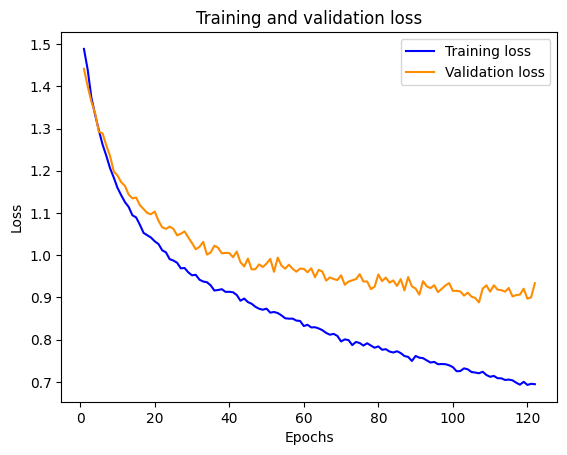

In [110]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

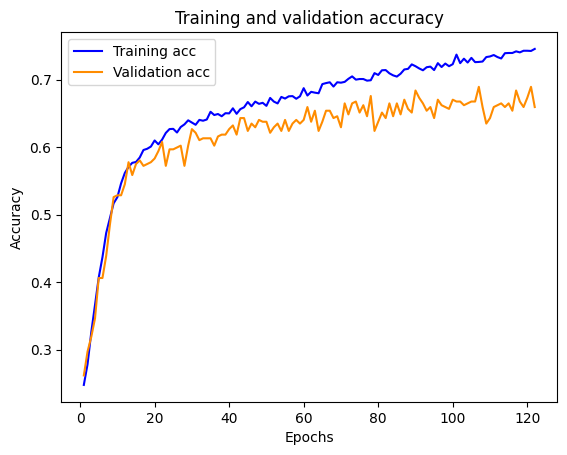

In [111]:
plt.clf()   # clear figure
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'darkorange', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [112]:
print(min(val_loss))
print(max(val_acc))

0.8882530927658081
0.6893733143806458


### Load dataset

In [113]:
def load_dataset(path, categories=None):
    data = load_files(path, categories=categories)
    paths = np.array(data['filenames'])
    targets = to_categorical(np.array(data['target']))
    return paths, targets

In [114]:
from sklearn.datasets import load_files
from tensorflow.keras.utils import to_categorical

test_files, test_targets = load_dataset('dataset/sorted_test')

In [115]:
test_files

array(['dataset/sorted_test\\2\\362.png',
       'dataset/sorted_test\\0\\67.png',
       'dataset/sorted_test\\2\\320.png',
       'dataset/sorted_test\\1\\144.png',
       'dataset/sorted_test\\0\\111.png',
       'dataset/sorted_test\\3\\464.png',
       'dataset/sorted_test\\1\\141.png',
       'dataset/sorted_test\\3\\454.png',
       'dataset/sorted_test\\0\\117.png',
       'dataset/sorted_test\\3\\434.png',
       'dataset/sorted_test\\3\\418.png',
       'dataset/sorted_test\\2\\316.png',
       'dataset/sorted_test\\1\\159.png',
       'dataset/sorted_test\\0\\70.png',
       'dataset/sorted_test\\1\\134.png',
       'dataset/sorted_test\\3\\424.png',
       'dataset/sorted_test\\2\\261.png',
       'dataset/sorted_test\\2\\250.png',
       'dataset/sorted_test\\2\\233.png',
       'dataset/sorted_test\\2\\322.png',
       'dataset/sorted_test\\2\\254.png',
       'dataset/sorted_test\\2\\200.png',
       'dataset/sorted_test\\2\\191.png',
       'dataset/sorted_test\\3\\439.

### Get tensors from paths

In [116]:
from tensorflow.keras.preprocessing import image  
from tensorflow.keras.applications.vgg16 import preprocess_input
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))

100%|██████████| 492/492 [00:00<00:00, 545.40it/s]


### Load model's weight

In [117]:
new_model.load_weights('efficientnet.model.hdf5')

### Calculate Testing loss and Testing accuracy

In [118]:
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))

16/16 [==============================] - 2s 45ms/step - loss: 0.9023 - accuracy: 0.6443

Testing loss: 0.9023
Testing accuracy: 0.6443


### Create Confusion matrix

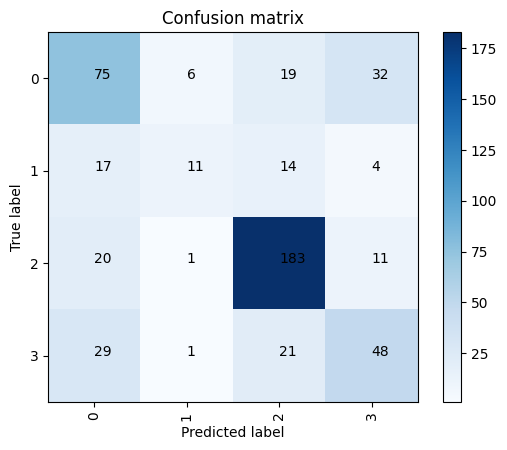

In [119]:
from sklearn.metrics import confusion_matrix

cm_labels = ['0','1','2','3']

cm = confusion_matrix(np.argmax(test_targets, axis=1),
                      np.argmax(new_model.predict(test_tensors), axis=1))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
indexes = np.arange(len(cm_labels))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j])
plt.xticks(indexes, cm_labels, rotation=90)
plt.xlabel('Predicted label')
plt.yticks(indexes, cm_labels)
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [ ]:
'''
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
bonus_file_source = './bonus/bonus/'
checkpointer = ModelCheckpoint(filepath='efficientnet.model.hdf5', save_best_only=True)
escallback = EarlyStopping(monitor='val_loss', patience=15)
for i in range(20):
    train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224,224), 
                                                         batch_size=128)
    history = new_model.fit_generator(train_batches, steps_per_epoch=train_batches.samples/train_batches.batch_size,
                   validation_data=valid_batches, 
                   validation_steps=valid_batches.samples/valid_batches.batch_size, 
                   epochs=300, 
                   verbose=1,
                   callbacks=[checkpointer, escallback])
    bonus_predict =new_model.predict(bonus_tensors)
    bonus =[]
    for k in range(len(bonus_predict)):
        max_score=0
        class_=0
        for j in range(4):
            if bonus_predict[k][j]>max_score:
                class_ =j
                max_score=bonus_predict[i][j]
        bonus.append(class_)
    for l in range(10):
        address =random.randrange(len(bonus))
        if bonus[address]==0:
            shutil.copy(bonus_file_source + bonus_name[address], file_destination+'0')
        if bonus[address]==1:
            shutil.copy(bonus_file_source + bonus_name[address], file_destination+'1')
        if bonus[address]==2:
            shutil.copy(bonus_file_source + bonus_name[address], file_destination+'2')
        if bonus[address]==3:
            shutil.copy(bonus_file_source + bonus_name[address], file_destination+'3')
'''

### Export CSV

In [120]:
test_files, test_targets = load_dataset('dataset', 'test')
test_files = sorted(test_files, key=lambda x:int(x.split('\\')[2].split('.')[0]))
test_tensors = preprocess_input(paths_to_tensor(test_files))

predict =new_model.predict(test_tensors)
y_classes = predict.argmax(axis=-1)
predict
import pandas as pd
result = pd.read_csv('sample_submission.csv')
result['Type'] = y_classes
result.to_csv('efficientnet.csv', index=None)

100%|██████████| 492/492 [00:00<00:00, 1350.34it/s]


### The End!